In [27]:
# Import Julia packages
using DrWatson
@quickactivate
using Revise
using LinearAlgebra
using DelimitedFiles
using SparseArrays
using StaticArrays
using BlockArrays
using CairoMakie
using UnPack
using FromFile
using GeometryBasics
using Random
using Colors
using JLD2
using LaTeXStrings
using Glob
using Printf
using ColorSchemes
using Statistics


@from "$(projectdir())/src/VertexModelContainers.jl" using VertexModelContainers
@from "$(projectdir())/src/Laplacians.jl" using Laplacians
@from "$(projectdir())/src/AnalysisFunctions.jl" using AnalysisFunctions
@from "$(projectdir())/src/CellProperties.jl" using CellProperties

In [816]:
f=Glob.glob("pseudo2D/100_disorder_L0_b/*L₀=0.5*","C:\\Users\\v35431nc\\Documents\\VM_code\\VertexModel\\data\\sims" )[end]
ff=Glob.glob("systemData*L₀=*.jld2",f)[end]
@unpack R, matrices, params = load(ff)
@unpack nCells,nVerts, Γa, ΓA, ΓL, L₀ = params
@unpack cellAreas,cellPerimeters, cellTensions, cellPressures, cellEdgeCount, edgeTangents,vertexAreas,A,Ā,B,B̄,C, ϵ, cellHeights = matrices
print(sort(norm.(edgeTangents)))
mkpath(datadir(f,"eigenmodes"))

[0.07094911534145622, 0.07289170894965273, 0.07508840817927304, 0.07513679082828728, 0.08011586618001697, 0.08146177978234617, 0.08265238286328826, 0.0833043128574606, 0.08429470816200062, 0.0852303651087642, 0.08672039868691953, 0.08921930386277278, 0.08978310704416803, 0.091563030387842, 0.09433479688716717, 0.09440421221867065, 0.09526787788858092, 0.09601992728739325, 0.09700002927867062, 0.09700089751031679, 0.09700102778637047, 0.09711321062583117, 0.09782448958569788, 0.09905779649713756, 0.0990580222000916, 0.1002431382596806, 0.10148876444910679, 0.10160171639948423, 0.10160480510842591, 0.10202344836211671, 0.10287280394614033, 0.10371804441017236, 0.1037213906119875, 0.10397605047866536, 0.10435213387950257, 0.10499719401394604, 0.10660493014100365, 0.10696047617767128, 0.1071257132882553, 0.10731298261517026, 0.10854178943689181, 0.10924990802468697, 0.10972553178212179, 0.10976076157761135, 0.10996404699162986, 0.1099957625717489, 0.11056066724833243, 0.11103364834508563, 

┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.MatricesContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605
┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.ParametersContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605


"C:\\Users\\v35431nc\\Documents\\VM_code\\VertexModel\\data\\sims\\pseudo2D\\100_disorder_L0_b\\L₀=0.5_nCells=100_realTimetMax=86400.0_ΓA=0.1_ΓL=0.1_Γa=0.1_24-10-29-18-20-07\\eigenmodes"

In [817]:
G=dropzeros!(sparse([Diagonal(4 .*Γa .+cellHeights.^2) Diagonal(2 .*Γa .*cellHeights)
Diagonal(2 .*Γa .*cellHeights) Diagonal(2 .*ΓL .+ Γa .*cellHeights.^2)]))
M=makeM(matrices)
g=vcat(cellPressures, cellTensions)
Lv=M'*G*M

X=makeX(params, matrices)

gX=Matrix{SMatrix{2,2,Float64,4}}(undef,nVerts,nVerts)
fill!(gX,@SMatrix zeros(2,2))
for α=1:2*nCells
    gX+=g[α]X[α, :,:]
end

In [818]:
H=Matrix(mortar(Lv)).+Matrix(mortar(gX))
evalH, evecH=eigen(H)
evecH=Matrix(qr(evecH).Q)

Lvevals,Lvevecs=LAPACK.syev!('V','U',deepcopy(Matrix(mortar(Lv))))


([-1.4880961951286074e-15, -1.4034246300846761e-15, -1.2913919719265369e-15, -1.2310208668968256e-15, -1.197676618681365e-15, -1.15523002454132e-15, -1.077973015703337e-15, -1.0174059747985697e-15, -9.846446646546534e-16, -9.505244267936245e-16  …  3.491184715043947, 3.4989216793231455, 3.5261006528244065, 3.5395886318070735, 3.5565058566772025, 3.5690096813031755, 3.5884303616841415, 3.6002749389196387, 3.609090114365955, 3.6173259510099185], [0.00889084384914021 -0.021170004761172544 … -0.017791082135974134 0.0035393343725072415; -0.02302352879325853 0.016994101306690358 … -0.0017558585452493107 0.003891457466542885; … ; 0.04102895970015506 -0.005854409865295411 … -0.026686517432244046 0.046305052769616405; -0.03467673093571697 -0.005016579918521624 … -0.024684448641562006 -0.005266749574602366])

In [819]:
D=Lvevecs'*Matrix(mortar(gX))*Lvevecs
DD=D + Diagonal(Lvevals)
evalDD,evecDD=LAPACK.syev!('V','U',deepcopy(DD))


evecmap=[evecDD[:,x]'*(Lvevecs'*Matrix(mortar(gX))*Lvevecs+Diagonal(Lvevals))*evecDD[:,x] for x in 1:2nVerts]
evmapLv=[evecDD[:,x]'*(Diagonal(Lvevals))*evecDD[:,x] for x in 1:2nVerts]
evmapgX=[evecDD[:,x]'*(Lvevecs'*Matrix(mortar(gX))*Lvevecs)*evecDD[:,x] for x in 1:2nVerts]



456-element Vector{Float64}:
 -9.995981977830642e-17
  3.142060443877382e-17
  1.7314451397145567e-7
  0.01706992421353583
  0.025431155038760818
  0.037328573913775885
  0.03642583184514167
  0.02896044924191296
 -0.007570514058750533
  0.04139945262604739
  ⋮
  8.066444831464544
  8.191148050242198
  8.972544859298196
  9.363216595437713
  9.545140404974301
  9.725924371846665
  9.83365643628255
 10.140124758300281
 10.79117201944245

In [ ]:
evalH

In [ ]:
n=LinRange(1, 2*nVerts, 2*nVerts)
fig = Figure()
ax=Axis(fig[1, 1], xlabel="n", ylabel="log₁₀(λₙ)", title="log₁₀(eigenvalues Lv,  MᵀGM+gX )")

scatter!(ax,n, log10.(abs.(Lvevals)), color=:blue, label="MᵀGM", markersize=5)
scatter!(ax,n, log10.(abs.(evalH)), color=:black, label="MᵀGM+gX", markersize=5)
#scatter!(ax,n, log10.(abs.(DDpptotevals)), color=:orange, label="D_total+diag(σ²)", markersize=5)
vlines!(ax,2*nVerts-(2*nCells) +0.5, color=:red)
vlines!(ax,2*nVerts-(nCells) +0.5, color=:red)
fig[1, 2] = Legend(fig, ax, framevisible = false)
save(datadir(f,"eigenmodes","Lv_MTGMgX_Evals.png"),fig)
fig

In [ ]:
perm=sortperm((abs.(evalH)))
nv=LinRange(1, 2*nVerts, 2*nVerts)
nc=LinRange(2*nVerts-2*nCells+1, 2*nVerts, 2*nCells)
fig = Figure()
set_theme!(figure_padding=5, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
ax=Axis(fig[1, 1], xlabel="Mode number, n", ylabel="λₙ", title="Γa = "*string(params.Γa)*", ΓA = "*string(params.ΓA)*", ΓL = "*string(params.ΓL)*", L₀ = "*string(params.L₀))
hidedecorations!(ax, grid=true, ticks=false, label=false,ticklabels = false)
#vspan!(197.5, 396.5, color = (:grey, 0.3))
scatter!(ax,nv[4:end], ((abs.(evalH[perm])))[4:end], color=:black,markersize=5, label=L"\lambda_n,\, \mathcal{H}")

#scatter!(ax,nv, (sort(abs.(evalLv))), color=ColorSchemes.seaborn_colorblind6[1],markersize=4, label=L"\lambda_n,\, \mathcal{L}_v^G")


scatter!(ax,nv[4:end], (((evmapLv[perm])))[4:end], color=ColorSchemes.seaborn_colorblind6[2],markersize=5, label=L"\lambda_n,\, \mathcal{L}_v^G")
scatter!(ax,nv[4:end], (((evmapgX[perm])))[4:end], color=ColorSchemes.seaborn_colorblind6[3],markersize=5, label=L"\lambda_n,\, \mathcal{H}")




elem_1 = [MarkerElement(color = :black, marker = :circle, markersize = 15)]

elem_2 = [MarkerElement(color = ColorSchemes.seaborn_colorblind6[2], marker = :circle, markersize = 15)]

elem_3 = [MarkerElement(color =ColorSchemes.seaborn_colorblind6[3], marker = :circle, markersize = 15)]

# # elem_4 = [MarkerElement(color =ColorSchemes.seaborn_colorblind6[3], marker = :circle, markersize = 12)]
Legend(fig[1, 2],#
    [elem_1, elem_2, elem_3],
    ["","",""],
    patchsize = (35, 35), rowgap = 10, framevisible = false)
resize_to_layout!(fig)

#ylims!(low=0.005)

#fig[1, 2] = Legend(fig, ax, framevisible = false)
save(datadir(f,"eigenmodes","Mode_contributions_Γa_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".png"),fig)
fig

In [ ]:
perm=sortperm((abs.(evalH)))
nv=LinRange(1, 2*nVerts, 2*nVerts)
nc=LinRange(2*nVerts-2*nCells+1, 2*nVerts, 2*nCells)
fig = Figure()
set_theme!(figure_padding=5, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
ax=Axis(fig[1, 1], xlabel="Mode number, n", ylabel="λₙ",yscale=log10, title="Γa = "*string(params.Γa)*", ΓA = "*string(params.ΓA)*", ΓL = "*string(params.ΓL)*", L₀ = "*string(params.L₀))
hidedecorations!(ax, grid=true, ticks=false, label=false,ticklabels = false)
#vspan!(197.5, 396.5, color = (:grey, 0.3))
scatter!(ax,nv[4:end], ((abs.(evalH[perm])))[4:end], color=:black,markersize=5, label=L"\lambda_n,\, \mathcal{H}")

#scatter!(ax,nv, (sort(abs.(evalLv))), color=ColorSchemes.seaborn_colorblind6[1],markersize=4, label=L"\lambda_n,\, \mathcal{L}_v^G")


scatter!(ax,nv[4:end], ((abs.(evmapLv[perm])))[4:end], color=ColorSchemes.seaborn_colorblind6[2],markersize=5, label=L"\lambda_n,\, \mathcal{L}_v^G")
scatter!(ax,nv[4:end], ((abs.(evmapgX[perm])))[4:end], color=ColorSchemes.seaborn_colorblind6[3],markersize=5, label=L"\lambda_n,\, \mathcal{H}")




elem_1 = [MarkerElement(color = :black, marker = :circle, markersize = 15)]

elem_2 = [MarkerElement(color = ColorSchemes.seaborn_colorblind6[2], marker = :circle, markersize = 15)]

elem_3 = [MarkerElement(color =ColorSchemes.seaborn_colorblind6[3], marker = :circle, markersize = 15)]

# # elem_4 = [MarkerElement(color =ColorSchemes.seaborn_colorblind6[3], marker = :circle, markersize = 12)]
Legend(fig[1, 2],#
    [elem_1, elem_2, elem_3],
    ["","",""],
    patchsize = (35, 35), rowgap = 10, framevisible = false)
resize_to_layout!(fig)

#ylims!(low=0.005)

#fig[1, 2] = Legend(fig, ax, framevisible = false)
save(datadir(f,"eigenmodes","Mode_contributions_Γa_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*"_log.png"),fig)
fig

In [ ]:
dUdHH=sum(cellAreas.^2 .+ Γa.*cellPerimeters.^2)
dPdH= 2.0 .*cellAreas.*cellHeights .+ 2.0 .* Γa .*cellPerimeters.-1
dTdH= (ΓA/2.0) .+ Γa.*cellHeights.*cellPerimeters .+ Γa .*(2.0 .*cellAreas .+ cellHeights.*cellPerimeters .-1)
dgdH=vcat(dPdH, dTdH)

dgdHM=vcat(((dgdH'*M)')...)

Hh=[[H;dgdHM']';vcat(dgdHM, dUdHH)']
evalHh, evecHh=eigen(Hh)
evecHh=real(Matrix(qr(evecHh).Q))

In [ ]:
n=LinRange(1, 2*nVerts, 2*nVerts+1)
nold=LinRange(1, 2*nVerts, 2*nVerts)

fig = Figure()
ax=Axis(fig[1, 1], xlabel="n", ylabel="log₁₀(λₙ)", title="log₁₀(eigenvalues MᵀGM+gX )")

scatter!(ax,n, log10.(abs.(evalHh)), color=:black, label="MᵀGM+gX", markersize=5)
#scatter!(ax,nold, log10.(abs.(evalH)), color=:blue, label="MᵀGM+gX", markersize=5)

vlines!(ax,2*nVerts-(2*nCells) +0.5, color=:red)
vlines!(ax,2*nVerts-(nCells) +0.5, color=:red)
fig[1, 2] = Legend(fig, ax, framevisible = false)
save(datadir(f,"eigenmodes","MTGMgX_Evals_Heightdep.png"),fig)
fig

In [ ]:
n=LinRange(1, 2*nVerts, 2*nVerts+1)


fig = Figure()
ax=Axis(fig[1, 1], xlabel="n", ylabel="ΔH", title="Height perturbation")

scatter!(ax,n, evecHh[end,:], color=:black, markersize=5)
Label( fig[0,:],"Γa = "*string(params.Γa)*", ΓA = "*string(params.ΓA)*", ΓL = "*string(params.ΓL)*", L₀ = "*string(params.L₀),fontsize = 26, color = (:black, 1))
resize_to_layout!(fig)
save(datadir(f,"eigenmodes","deltaH_Γa_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".png"),fig)

fig

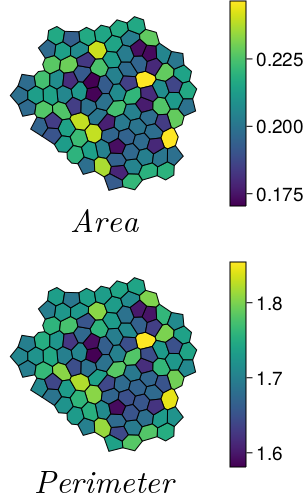

In [811]:
cellPolygons = makeCellPolygons(R,params,matrices)
Aevlims=(minimum(abs.(cellAreas[1:nCells])), maximum(abs.(cellAreas[1:nCells])))
Levlims=(minimum(abs.(cellPerimeters[1:nCells])), maximum(abs.(cellPerimeters[1:nCells])))
set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(1500,500))

a1=Axis(fig[1,1],aspect=DataAspect())
a2=Axis(fig[2,1],aspect=DataAspect())
hidedecorations!(a1)
hidespines!(a1)
hidedecorations!(a2)
hidespines!(a2)
for i=1:nCells
    poly!(a1,cellPolygons[i],color=cellAreas[i],colormap=:viridis,colorrange=Aevlims, strokecolor=(:black,1.0),strokewidth=1)
    poly!(a2,cellPolygons[i],color=cellPerimeters[i],colormap=:viridis,colorrange=Levlims, strokecolor=(:black,1.0),strokewidth=1)
end
#Label(fig[2,1,Bottom()],"λ_"*string(n)*" = "*@sprintf("%.5E", evals[n]),fontsize = 32)

#hidedecorations!(ax22)
#hidespines!(ax22)

colsize!(fig.layout,1,Aspect(1,1.0))


Colorbar(fig[1,2],limits=colorrange=Aevlims,colormap=:viridis,flipaxis=true)
Colorbar(fig[2,2],limits=colorrange=Levlims,colormap=:viridis,flipaxis=true)


Label(fig[1,1,Bottom()],string(L"Area"),fontsize = 32, rotation=0)
Label(fig[2,1,Bottom()],string(L"Perimeter"),fontsize = 32, rotation=0)
#Label( fig[0,:],"Γ = "*string(params.γ)*", L₀ = "*string(params.L₀)*", δL = "*string(params.δL),fontsize = 32, color = (:black, 1))
resize_to_layout!(fig)
save(datadir(f,"eigenmodes","Area_Perimeter.png"),fig)
fig

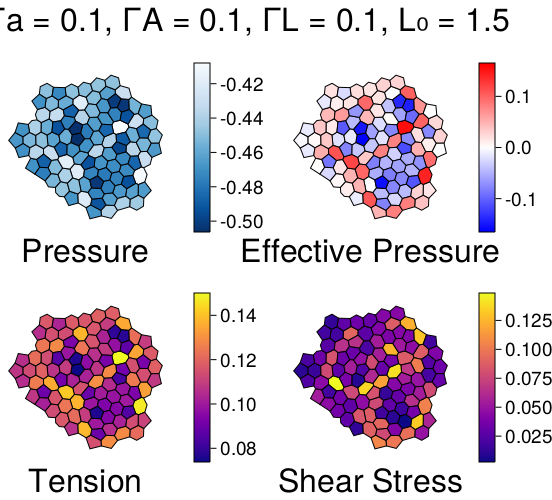

CairoMakie.Screen{IMAGE}


In [812]:
Peff=getPeff(params, matrices)
#Peff=cellPressures+(cellTensions.*cellPerimeters)./(2*cellAreas)

cellQ, cellJ=makeCellQandJ(params, matrices)
cellShearStress=getShearStress(params, matrices, cellJ)

cellPolygons = makeCellPolygons(R,params,matrices)
@unpack cellAreas, cellPerimeters, cellPressures, cellTensions = matrices
Plims=(minimum(cellPressures[1:nCells]), maximum(cellPressures[1:nCells]))
Tlims=(minimum(cellTensions[1:nCells]), maximum(cellTensions[1:nCells]))
Pefflims=(-maximum(abs.(Peff)), maximum(abs.(Peff)))
ShStlims=(minimum(cellShearStress[1:nCells]), maximum(cellShearStress[1:nCells]))
set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(1500,500))

a11=Axis(fig[1,1],aspect=DataAspect())
a21=Axis(fig[2,1],aspect=DataAspect())
a13=Axis(fig[1,3],aspect=DataAspect())
a23=Axis(fig[2,3],aspect=DataAspect())
hidedecorations!(a11)
hidespines!(a11)
hidedecorations!(a21)
hidespines!(a21)
hidedecorations!(a13)
hidespines!(a13)
hidedecorations!(a23)
hidespines!(a23)
for i=1:nCells
    poly!(a11,cellPolygons[i],color=cellPressures[i],colormap=cgrad(:Blues_9, rev=true),colorrange=Plims, strokecolor=(:black,1.0),strokewidth=1)
    poly!(a21,cellPolygons[i],color=cellTensions[i],colormap=:plasma,colorrange=Tlims, strokecolor=(:black,1.0),strokewidth=1)
    poly!(a13,cellPolygons[i],color=Peff[i],colormap=:bwr,colorrange=Pefflims, strokecolor=(:black,1.0),strokewidth=1)
    poly!(a23,cellPolygons[i],color=cellShearStress[i],colormap=:plasma,colorrange=ShStlims, strokecolor=(:black,1.0),strokewidth=1)
end
#Label(fig[2,1,Bottom()],"λ_"*string(n)*" = "*@sprintf("%.5E", evals[n]),fontsize = 32)

#hidedecorations!(ax22)
#hidespines!(ax22)

colsize!(fig.layout,1,Aspect(1,1.0))

colsize!(fig.layout,3,Aspect(1,1.0))


Colorbar(fig[1,2],limits=colorrange=Plims,colormap=cgrad(:Blues_9, rev=true),flipaxis=true)
Colorbar(fig[2,2],limits=colorrange=Tlims,colormap=:plasma,flipaxis=true)
Colorbar(fig[1,4],limits=colorrange=Pefflims,colormap=:bwr,flipaxis=true)
Colorbar(fig[2,4],limits=colorrange=ShStlims,colormap=:plasma,flipaxis=true)

Label(fig[1,1,Bottom()],"Pressure",fontsize = 32, rotation=0)
Label(fig[2,1,Bottom()],"Tension",fontsize = 32, rotation=0)

Label(fig[1,3,Bottom()],"Effective Pressure",fontsize = 32, rotation=0)
Label(fig[2,3,Bottom()],"Shear Stress",fontsize = 32, rotation=0)
Label( fig[0,:],"Γa = "*string(params.Γa)*", ΓA = "*string(params.ΓA)*", ΓL = "*string(params.ΓL)*", L₀ = "*string(params.L₀),fontsize = 32, color = (:black, 1))
resize_to_layout!(fig)
#save(datadir(f,"eigenmodes","Stress.png"),fig)
save(datadir(f,"eigenmodes","stress_pressure_Γa_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".png"),fig)

display(fig)

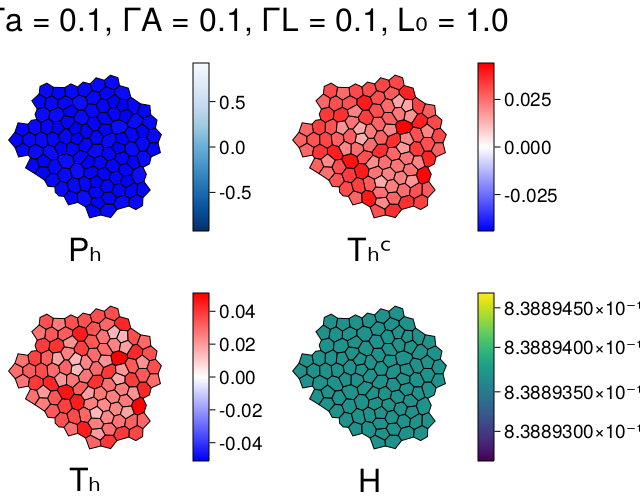

CairoMakie.Screen{IMAGE}


In [796]:
h=mean(cellHeights)
Ph=(cellAreas.*h .-1.0)
Th=Γa.*(2.0.*cellAreas .+ h.*cellPerimeters .- 1.0)
Thc=ΓL.*(cellPerimeters.-L₀)


cellPolygons = makeCellPolygons(R,params,matrices)
@unpack cellAreas, cellPerimeters, cellPressures, cellTensions = matrices
Plims=(-maximum(abs.(Ph)), maximum(abs.(Ph)))
Tlims=(-maximum(abs.(Th)), maximum(abs.(Th)))
Thclims=(-maximum(abs.(Thc)), maximum(abs.(Thc)))
Hlims=(minimum(cellHeights[1:nCells])-1e-6, maximum(cellHeights[1:nCells])+1e-6)
set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(1500,500))

a11=Axis(fig[1,1],aspect=DataAspect())
a21=Axis(fig[2,1],aspect=DataAspect())
a13=Axis(fig[1,3],aspect=DataAspect())
a23=Axis(fig[2,3],aspect=DataAspect())
hidedecorations!(a11)
hidespines!(a11)
hidedecorations!(a21)
hidespines!(a21)
hidedecorations!(a13)
hidespines!(a13)
hidedecorations!(a23)
hidespines!(a23)
for i=1:nCells
    poly!(a11,cellPolygons[i],color=Ph[i],colormap=:bwr,colorrange=Plims, strokecolor=(:black,1.0),strokewidth=1)
    poly!(a21,cellPolygons[i],color=Th[i],colormap=:bwr,colorrange=Tlims, strokecolor=(:black,1.0),strokewidth=1)
    poly!(a13,cellPolygons[i],color=Thc[i],colormap=:bwr,colorrange=Thclims, strokecolor=(:black,1.0),strokewidth=1)
    poly!(a23,cellPolygons[i],color=cellHeights[i],colormap=:viridis,colorrange=Hlims, strokecolor=(:black,1.0),strokewidth=1)
end
#Label(fig[2,1,Bottom()],"λ_"*string(n)*" = "*@sprintf("%.5E", evals[n]),fontsize = 32)

#hidedecorations!(ax22)
#hidespines!(ax22)

colsize!(fig.layout,1,Aspect(1,1.0))

colsize!(fig.layout,3,Aspect(1,1.0))


Colorbar(fig[1,2],limits=colorrange=Plims,colormap=colormap=cgrad(:Blues_9, rev=true),flipaxis=true)
Colorbar(fig[2,2],limits=colorrange=Tlims,colormap=:bwr,flipaxis=true)
Colorbar(fig[1,4],limits=colorrange=Thclims,colormap=:bwr,flipaxis=true)
Colorbar(fig[2,4],limits=colorrange=Hlims,colormap=:viridis,flipaxis=true)

Label(fig[1,1,Bottom()],"Pₕ",fontsize = 32, rotation=0)
Label(fig[2,1,Bottom()],"Tₕ",fontsize = 32, rotation=0)

Label(fig[1,3,Bottom()],"Tₕᶜ",fontsize = 32, rotation=0)
Label(fig[2,3,Bottom()],"H",fontsize = 32, rotation=0)
Label( fig[0,:],"Γa = "*string(params.Γa)*", ΓA = "*string(params.ΓA)*", ΓL = "*string(params.ΓL)*", L₀ = "*string(params.L₀),fontsize = 32, color = (:black, 1))
resize_to_layout!(fig)
#save(datadir(f,"eigenmodes","Stress.png"),fig)
save(datadir(f,"eigenmodes","pressure_tension_Γa_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".png"),fig)

display(fig)

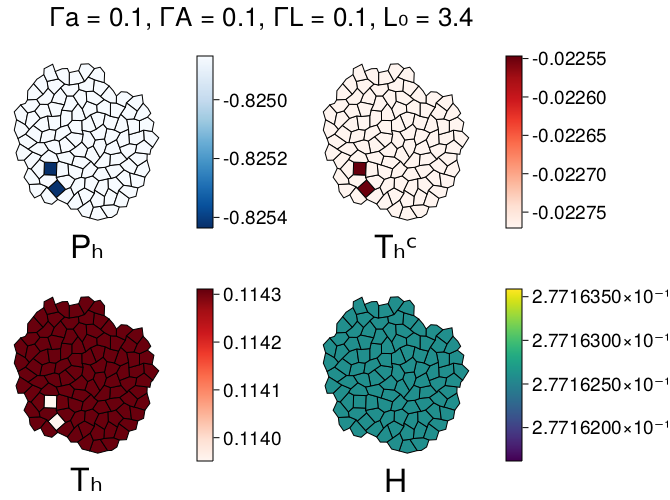

CairoMakie.Screen{IMAGE}


In [718]:
h=mean(cellHeights)
Ph=(cellAreas.*h .-1.0)
Th=Γa.*(2.0.*cellAreas .+ h.*cellPerimeters .- 1.0)
Thc=ΓL.*(cellPerimeters.-L₀)


cellPolygons = makeCellPolygons(R,params,matrices)
@unpack cellAreas, cellPerimeters, cellPressures, cellTensions = matrices
Plims=(minimum(Ph), maximum(Ph))
Tlims=(minimum(Th), maximum(Th))
Thclims=(minimum(Thc), maximum(Thc))
Hlims=(minimum(cellHeights[1:nCells])-1e-6, maximum(cellHeights[1:nCells])+1e-6)
set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(1500,500))

a11=Axis(fig[1,1],aspect=DataAspect())
a21=Axis(fig[2,1],aspect=DataAspect())
a13=Axis(fig[1,3],aspect=DataAspect())
a23=Axis(fig[2,3],aspect=DataAspect())
hidedecorations!(a11)
hidespines!(a11)
hidedecorations!(a21)
hidespines!(a21)
hidedecorations!(a13)
hidespines!(a13)
hidedecorations!(a23)
hidespines!(a23)
for i=1:nCells
    poly!(a11,cellPolygons[i],color=Ph[i],colormap=cgrad(:Blues_9, rev=true),colorrange=Plims, strokecolor=(:black,1.0),strokewidth=1)
    poly!(a21,cellPolygons[i],color=Th[i],colormap=cgrad(:Reds_9),colorrange=Tlims, strokecolor=(:black,1.0),strokewidth=1)
    poly!(a13,cellPolygons[i],color=Thc[i],colormap=cgrad(:Reds_9),colorrange=Thclims, strokecolor=(:black,1.0),strokewidth=1)
    poly!(a23,cellPolygons[i],color=cellHeights[i],colormap=:viridis,colorrange=Hlims, strokecolor=(:black,1.0),strokewidth=1)
end
#Label(fig[2,1,Bottom()],"λ_"*string(n)*" = "*@sprintf("%.5E", evals[n]),fontsize = 32)

#hidedecorations!(ax22)
#hidespines!(ax22)

colsize!(fig.layout,1,Aspect(1,1.0))

colsize!(fig.layout,3,Aspect(1,1.0))


Colorbar(fig[1,2],limits=colorrange=Plims,colormap=cgrad(:Blues_9, rev=true),flipaxis=true)
Colorbar(fig[2,2],limits=colorrange=Tlims,colormap=cgrad(:Reds_9),flipaxis=true)
Colorbar(fig[1,4],limits=colorrange=Thclims,colormap=cgrad(:Reds_9),flipaxis=true)
Colorbar(fig[2,4],limits=colorrange=Hlims,colormap=:viridis,flipaxis=true)

Label(fig[1,1,Bottom()],"Pₕ",fontsize = 32, rotation=0)
Label(fig[2,1,Bottom()],"Tₕ",fontsize = 32, rotation=0)

Label(fig[1,3,Bottom()],"Tₕᶜ",fontsize = 32, rotation=0)
Label(fig[2,3,Bottom()],"H",fontsize = 32, rotation=0)
Label( fig[0,:],"Γa = "*string(params.Γa)*", ΓA = "*string(params.ΓA)*", ΓL = "*string(params.ΓL)*", L₀ = "*string(params.L₀),fontsize = 26, color = (:black, 1))
resize_to_layout!(fig)
#save(datadir(f,"eigenmodes","Stress.png"),fig)
save(datadir(f,"eigenmodes","pressure_tension_Γa_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*"_b_r.png"),fig)

display(fig)

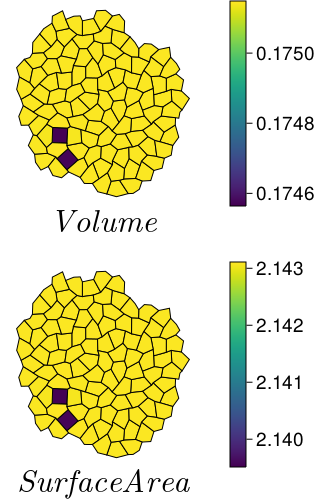

In [719]:
cellVolumes=cellAreas.*cellHeights
cellSurface=2.0.*cellAreas+cellPerimeters.*cellHeights
cellPolygons = makeCellPolygons(R,params,matrices)
Vlims=(minimum(abs.(cellVolumes[1:nCells])), maximum(abs.(cellVolumes[1:nCells])))
alims=(minimum(abs.(cellSurface[1:nCells])), maximum(abs.(cellSurface[1:nCells])))
set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(1500,500))

a1=Axis(fig[1,1],aspect=DataAspect())
a2=Axis(fig[2,1],aspect=DataAspect())
hidedecorations!(a1)
hidespines!(a1)
hidedecorations!(a2)
hidespines!(a2)
for i=1:nCells
    poly!(a1,cellPolygons[i],color=cellVolumes[i],colormap=:viridis,colorrange=Vlims, strokecolor=(:black,1.0),strokewidth=1)
    poly!(a2,cellPolygons[i],color=cellSurface[i],colormap=:viridis,colorrange=alims, strokecolor=(:black,1.0),strokewidth=1)
end
#Label(fig[2,1,Bottom()],"λ_"*string(n)*" = "*@sprintf("%.5E", evals[n]),fontsize = 32)

#hidedecorations!(ax22)
#hidespines!(ax22)

colsize!(fig.layout,1,Aspect(1,1.0))


Colorbar(fig[1,2],limits=colorrange=Vlims,colormap=:viridis,flipaxis=true)
Colorbar(fig[2,2],limits=colorrange=alims,colormap=:viridis,flipaxis=true)


Label(fig[1,1,Bottom()],string(L"Volume"),fontsize = 32, rotation=0)
Label(fig[2,1,Bottom()],string(L"Surface Area"),fontsize = 32, rotation=0)
#Label( fig[0,:],"Γ = "*string(params.γ)*", L₀ = "*string(params.L₀)*", δL = "*string(params.δL),fontsize = 32, color = (:black, 1))
resize_to_layout!(fig)
save(datadir(f,"eigenmodes","vol_sa.png"),fig)
fig

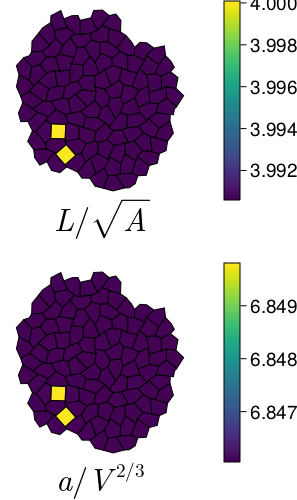

In [720]:
cellVolumes=cellAreas.*cellHeights
cellSurface=2.0.*cellAreas+cellPerimeters.*cellHeights
shapeParam2D=cellPerimeters./(sqrt.(cellAreas))
shapeParam3D=cellSurface./(cellVolumes.^(2/3))
cellPolygons = makeCellPolygons(R,params,matrices)
alims=(minimum(abs.(shapeParam2D[1:nCells])), maximum(abs.(shapeParam2D[1:nCells])))
blims=(minimum(abs.(shapeParam3D[1:nCells])), maximum(abs.(shapeParam3D[1:nCells])))
set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(1500,500))

a1=Axis(fig[1,1],aspect=DataAspect())
a2=Axis(fig[2,1],aspect=DataAspect())
hidedecorations!(a1)
hidespines!(a1)
hidedecorations!(a2)
hidespines!(a2)
for i=1:nCells
    poly!(a1,cellPolygons[i],color=shapeParam2D[i],colormap=:viridis,colorrange=alims, strokecolor=(:black,1.0),strokewidth=1)
    poly!(a2,cellPolygons[i],color=shapeParam3D[i],colormap=:viridis,colorrange=blims, strokecolor=(:black,1.0),strokewidth=1)
end
#Label(fig[2,1,Bottom()],"λ_"*string(n)*" = "*@sprintf("%.5E", evals[n]),fontsize = 32)

#hidedecorations!(ax22)
#hidespines!(ax22)

colsize!(fig.layout,1,Aspect(1,1.0))


Colorbar(fig[1,2],limits=colorrange=alims,colormap=:viridis,flipaxis=true)
Colorbar(fig[2,2],limits=colorrange=blims,colormap=:viridis,flipaxis=true)


Label(fig[1,1,Bottom()],string(L"L/\sqrt{A}"),fontsize = 32, rotation=0)
Label(fig[2,1,Bottom()],string(L"a/V^{2/3}"),fontsize = 32, rotation=0)
#Label( fig[0,:],"Γ = "*string(params.γ)*", L₀ = "*string(params.L₀)*", δL = "*string(params.δL),fontsize = 32, color = (:black, 1))
resize_to_layout!(fig)
save(datadir(f,"eigenmodes","shapeparam.png"),fig)
fig

In [721]:
H

474×474 Matrix{Float64}:
  4.71479e-5   -0.00236483   0.0        …   0.0         0.0         0.0
 -0.00236483    0.242757     0.0            0.0         0.0         0.0
  0.0           0.0          0.0138202      0.0         0.0         0.0
  0.0           0.0         -0.0392345      0.0         0.0         0.0
  0.00135692   -0.341323    -0.0400627      0.0         0.0         0.0
 -0.000136976   0.105721    -0.0578915  …   0.0         0.0         0.0
  0.0           0.0          0.0413942      0.0         0.0         0.0
  0.0           0.0         -0.0310555      0.0         0.0         0.0
  0.0           0.0          0.0            0.0         0.0         0.0
  0.0           0.0          0.0            0.0         0.0         0.0
  ⋮                                     ⋱                          
  0.0           0.0          0.0        …   0.0         0.0         0.0
  0.0           0.0          0.0            0.0         0.0         0.0
  0.0           0.0          0.0           

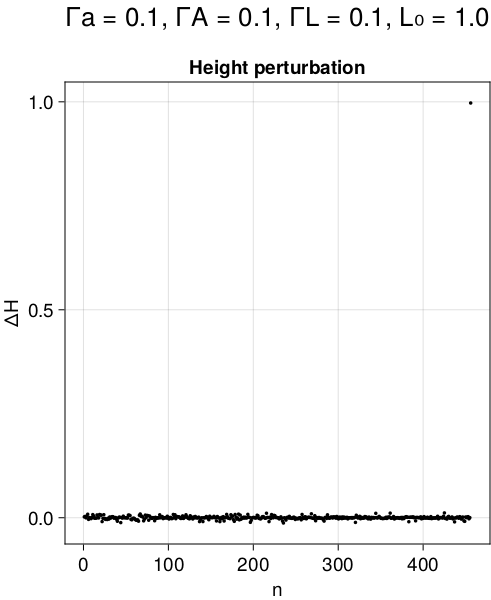

In [760]:
real(evalH)

474-element Vector{Float64}:
 -1.0478737094560278e-5
 -6.796242658640149e-6
 -5.369913699852904e-6
 -4.988516009502383e-6
 -4.4190464967272545e-6
 -4.170239959067498e-6
 -3.196074321628214e-6
 -2.165493194181505e-6
 -1.7745940997501743e-6
 -1.6025647851696634e-6
  ⋮
  3.2001709636588376
  3.2107936916048443
  3.231081317026765
  3.255889219419394
  3.3085705435931465
  3.391955547746599
  3.4053224961446507
  3.5825605359998423
  3.7471965265181133

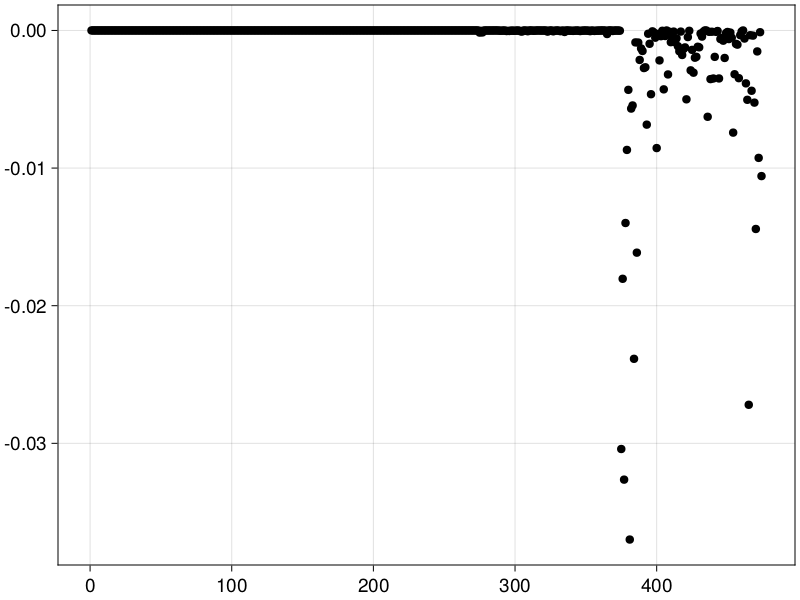

In [764]:
plot(evalHh[1:end-1]-real(evalH))